<a href="https://colab.research.google.com/github/davidanagy/DS-Unit-2-Kaggle-Challenge/blob/master/module1/assignment_kaggle_challenge_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 1

## Assignment
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what other columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What other columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [75]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [76]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [77]:
train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [78]:
train, val = train_test_split(train, stratify=train['status_group'], random_state=77)

train.shape, val.shape

((44550, 41), (14850, 41))

In [79]:
train.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,44550.000000,44550.000000,44550.000000,44550.000000,4.455000e+04,44550.000000,44550.000000,44550.000000,44550.000000,44550.000000
mean,37143.024871,320.565308,664.057755,34.065060,-5.713159e+00,0.473692,15.347587,5.629001,180.142626,1296.927340
std,21404.799050,3150.477970,692.725185,6.606202,2.951366e+00,11.594878,17.685514,9.650221,484.178119,952.804879
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18674.250000,0.000000,0.000000,33.092540,-8.555150e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37112.500000,0.000000,362.000000,34.902670,-5.026314e+00,0.000000,12.000000,3.000000,25.000000,1985.000000
75%,55592.750000,25.000000,1316.000000,37.181739,-3.327720e+00,0.000000,17.000000,5.000000,210.000000,2004.000000
max,74247.000000,350000.000000,2628.000000,40.344301,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [80]:
# The weirdest column vis-a-vis zeroes here is "amount_tsh." On Friday I just deleted it because there's so many zeroes.
# But maybe it's actually informative? Let's check.

tsh = train[['amount_tsh', 'status_group']]
tsh_zero = tsh[tsh['amount_tsh'] == 0]
tsh_not_zero = tsh[tsh['amount_tsh'] != 0]
tsh_zero['status_group'].value_counts(normalize=True)

functional                 0.472360
non functional             0.454510
functional needs repair    0.073129
Name: status_group, dtype: float64

In [81]:
tsh_not_zero['status_group'].value_counts(normalize=True)

# There's actually a pretty big difference between these groups. This makes me think that,
# while some of the zeroes should really be NaN, others are "actual" zeroes. As there's no way
# to distinguish between those, I'll just keep this column as-is.

functional                 0.708430
non functional             0.219933
functional needs repair    0.071637
Name: status_group, dtype: float64

In [0]:
import numpy as np

def remove_zeroes(X):
  X = X.copy()
  
  X['latitude'] = X['latitude'].replace(-2e-08, 0)
  
  zeroes = ['gps_height', 'longitude', 'latitude', 'population', 'construction_year']
  for col in zeroes:
    X[col] = X[col].replace(0, np.nan)
  
  return X

In [0]:
def datetime_features(X):
  X = X.copy()
  
  X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
  
  X['year_recorded'] = X['date_recorded'].dt.year
  
  X['construction_year'] = X['construction_year'].fillna(np.around(np.mean(X['construction_year']), decimals=0))
  
  X['time_to_inspection'] = X['year_recorded'] - X['construction_year']
  
  return X

In [84]:
train.describe(exclude=np.number)

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
count,44550,41823,41813,44550,44550,44282,44550,44550,44550,41991,44550,41637,23305,42236,44550,44550,44550,44550,44550,44550,44550,44550,44550,44550,44550,44550,44550,44550,44550,44550,44550
unique,348,1650,1865,29028,9,16660,21,125,2079,2,1,12,2493,2,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6,3
top,2013-02-03,Government Of Tanzania,DWE,none,Lake Victoria,Shuleni,Iringa,Njombe,Igosi,True,GeoData Consultants Ltd,VWC,K,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
freq,428,6810,13040,2648,7729,388,3962,1896,225,38190,44550,27547,506,29174,19981,19981,19981,30326,39347,19073,19073,38113,38113,24927,24927,12682,12682,34290,21320,25890,24194


In [0]:
def drop_redundant(X):
  X = X.copy()
  
  redundant_cols = ['recorded_by', 'extraction_type_group', 'extraction_type_class', 'management_group', 'payment_type',
                   'quality_group', 'quantity_group', 'source_type', 'source_class', 'waterpoint_type_group',
                   'region_code', 'district_code', 'date_recorded']
  
  for col in redundant_cols:
    X = X.drop(col, axis=1)
    
  return X

In [0]:
def reduce_cardinality(X):
  X = X.copy()
  
  cardinality = X.select_dtypes(exclude='number').nunique()
  
  high_cardinality = cardinality[cardinality > 50].index.tolist()
  
  for feature in high_cardinality:
    top10 = X[feature].value_counts()[:10].index
    X.loc[~X[feature].isin(top10), feature] = 'OTHER'
  
  return X

In [0]:
def engineer_features(X):
  X = X.copy()
  
  X = remove_zeroes(X)
  X = datetime_features(X)
  X = drop_redundant(X)
  X = reduce_cardinality(X)
  
  return X

In [88]:
train = engineer_features(train)
train.head()

,id,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,management,payment,water_quality,quantity,source,waterpoint_type,status_group,year_recorded,time_to_inspection
58517,47871,0.0,OTHER,NaN,OTHER,NaN,NaN,OTHER,0,Lake Victoria,OTHER,Shinyanga,Bariadi,OTHER,NaN,True,WUG,OTHER,False,1997.0,nira/tanira,wug,never pay,soft,enough,shallow well,hand pump,functional,2013,16.0
53717,68517,0.0,Government Of Tanzania,NaN,RWE,31.770808,-1.003277,OTHER,0,Lake Victoria,OTHER,Kagera,OTHER,OTHER,NaN,True,VWC,OTHER,True,1997.0,gravity,vwc,never pay,soft,insufficient,spring,communal standpipe,non functional,2011,14.0
5580,19065,0.0,OTHER,NaN,OTHER,33.405885,-3.504091,OTHER,0,Internal,OTHER,Shinyanga,OTHER,OTHER,NaN,True,WUG,OTHER,True,1997.0,nira/tanira,wug,never pay,soft,insufficient,shallow well,hand pump,functional,2012,15.0
47950,22748,0.0,OTHER,NaN,OTHER,36.117722,-6.869506,OTHER,0,Rufiji,OTHER,Dodoma,OTHER,OTHER,NaN,True,VWC,OTHER,True,1997.0,gravity,vwc,never pay,soft,seasonal,rainwater harvesting,communal standpipe,non functional,2011,14.0
10488,15740,0.0,OTHER,NaN,OTHER,NaN,NaN,OTHER,0,Lake Victoria,Madukani,Mwanza,OTHER,OTHER,NaN,NaN,WUG,OTHER,False,1997.0,india mark iii,wug,unknown,soft,enough,shallow well,hand pump,functional,2012,15.0


In [89]:
train.describe(exclude=np.number)

,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,scheme_management,scheme_name,permit,extraction_type,management,payment,water_quality,quantity,source,waterpoint_type,status_group
count,44550,44550,44550,44550,44550,44550,44550,44550,41991,41637,44550,42236,44550,44550,44550,44550,44550,44550,44550,44550
unique,11,11,11,9,11,21,11,11,2,12,11,2,18,12,7,8,5,10,7,3
top,OTHER,OTHER,OTHER,Lake Victoria,OTHER,Iringa,OTHER,OTHER,True,VWC,OTHER,True,gravity,vwc,never pay,soft,enough,spring,communal standpipe,functional
freq,27724,24722,38381,7729,42244,3962,35167,42902,38190,27547,41400,29174,19981,30326,19073,38113,24927,12682,21320,24194


In [0]:
features = train.columns.tolist()
features.remove('id')
features.remove('status_group')

In [91]:
features

['amount_tsh',
 'funder',
 'gps_height',
 'installer',
 'longitude',
 'latitude',
 'wpt_name',
 'num_private',
 'basin',
 'subvillage',
 'region',
 'lga',
 'ward',
 'population',
 'public_meeting',
 'scheme_management',
 'scheme_name',
 'permit',
 'construction_year',
 'extraction_type',
 'management',
 'payment',
 'water_quality',
 'quantity',
 'source',
 'waterpoint_type',
 'year_recorded',
 'time_to_inspection']

In [0]:
target = 'status_group'

In [0]:
val = engineer_features(val)
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

In [94]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(max_depth=20, random_state=80)
)

pipeline.fit(X_train, y_train)
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

Train Accuracy 0.895331088664422
Validation Accuracy 0.7705050505050505


In [95]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(min_samples_leaf=25, random_state=80)
)

pipeline.fit(X_train, y_train)
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

Train Accuracy 0.7981818181818182
Validation Accuracy 0.7683501683501683


In [96]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(min_samples_leaf=15, random_state=80)
)

pipeline.fit(X_train, y_train)
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

Train Accuracy 0.8189225589225589
Validation Accuracy 0.7721885521885522


In [97]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(random_state=80)
)

pipeline.fit(X_train, y_train)
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

Train Accuracy 0.9970145903479237
Validation Accuracy 0.7551515151515151


In [98]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(min_samples_leaf=10, random_state=80)
)

pipeline.fit(X_train, y_train)
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

Train Accuracy 0.8373961840628508
Validation Accuracy 0.7649158249158249


In [99]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(max_depth=30, random_state=80)
)

pipeline.fit(X_train, y_train)
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

Train Accuracy 0.9742312008978675
Validation Accuracy 0.7567003367003367


In [100]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(max_depth=10, random_state=80)
)

pipeline.fit(X_train, y_train)
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

Train Accuracy 0.762648709315376
Validation Accuracy 0.7462626262626263


In [101]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(max_depth=20, min_samples_leaf=15, random_state=80)
)

pipeline.fit(X_train, y_train)
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

Train Accuracy 0.8085072951739618
Validation Accuracy 0.7707070707070707


In [102]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(min_samples_leaf=18, random_state=80)
)

pipeline.fit(X_train, y_train)
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

Train Accuracy 0.8108193041526375
Validation Accuracy 0.7700336700336701


In [103]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(min_samples_leaf=14, random_state=80)
)

pipeline.fit(X_train, y_train)
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

Train Accuracy 0.8223120089786756
Validation Accuracy 0.7726599326599327


In [104]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(min_samples_leaf=13, random_state=80)
)

pipeline.fit(X_train, y_train)
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

Train Accuracy 0.8252749719416386
Validation Accuracy 0.7713131313131313


In [105]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(min_samples_leaf=14, random_state=80)
)

pipeline.fit(X_train, y_train)
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

Train Accuracy 0.8223120089786756
Validation Accuracy 0.7726599326599327


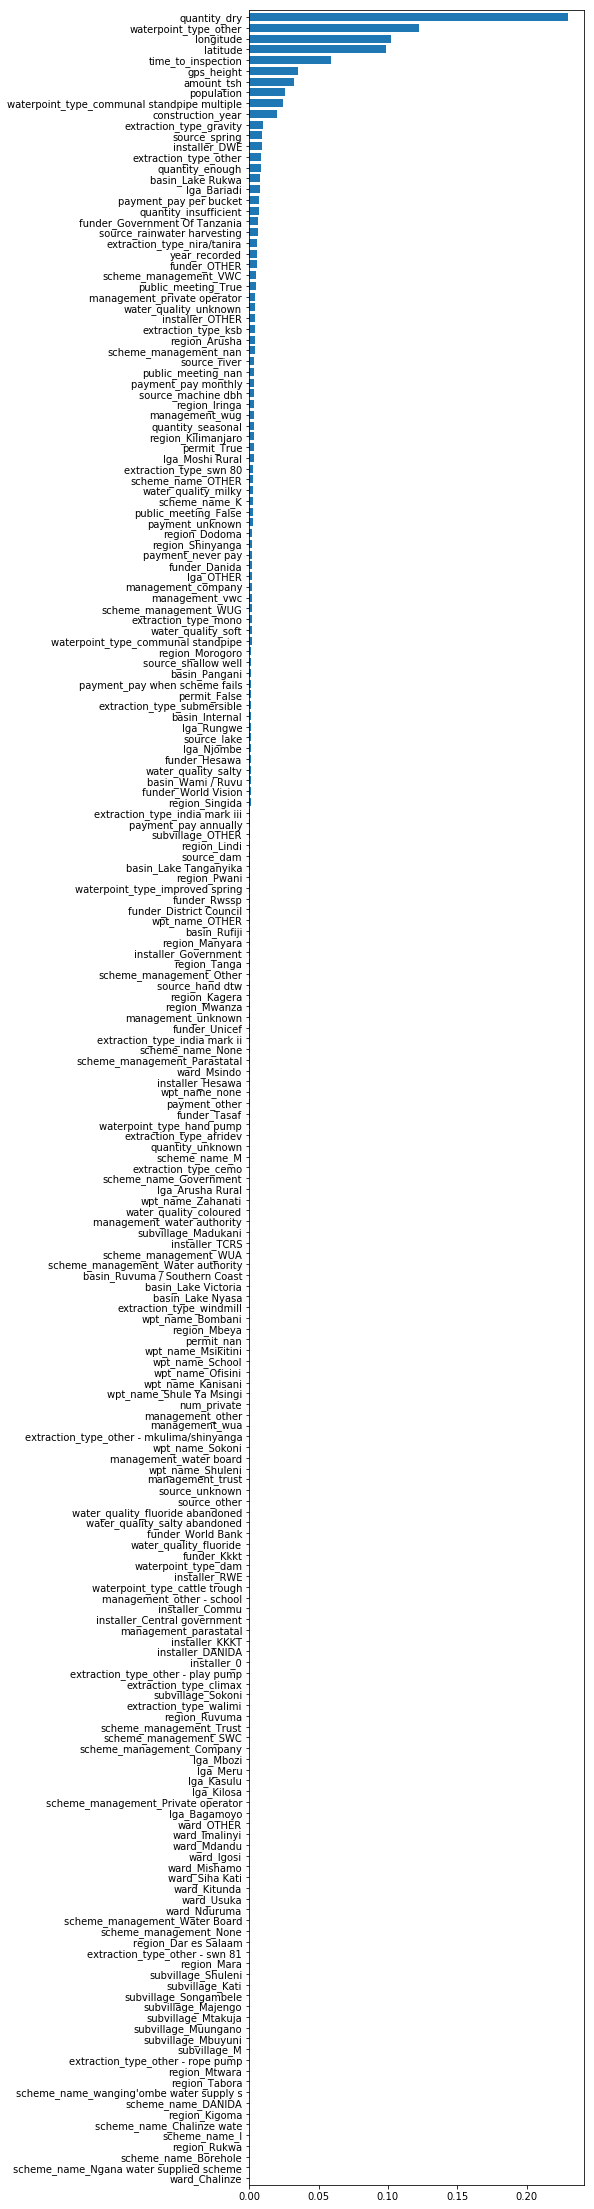

In [106]:
import matplotlib.pyplot as plt

model = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['onehotencoder']

encoded_cols = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_cols)
fig, ax = plt.subplots()
fig.set_size_inches(6, 40)
importances.sort_values().plot.barh(width=0.75, ax=ax);

In [109]:
test = engineer_features(test)
X_test = test.drop('id', axis=1)
y_pred = pipeline.predict(X_test)


array(['functional', 'functional', 'functional', ..., 'functional',
       'functional', 'non functional'], dtype=object)

In [110]:
sample_submission.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,functional
4,49871,functional


In [112]:
y_pred = pd.DataFrame(y_pred, columns=['status_group'])
y_pred.head()

,status_group
0,functional
1,functional
2,functional
3,non functional
4,functional


In [113]:
submission_id = pd.DataFrame(test['id'], columns=['id'])
submission_id.head()

,id
0,50785
1,51630
2,17168
3,45559
4,49871


In [116]:
submission_id.shape, y_pred.shape

((14358, 1), (14358, 1))

In [117]:
submission = pd.concat([submission_id, y_pred], axis=1)
submission.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [0]:
submission.to_csv('water-submission-03.csv', index = None, header=True)

In [120]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    IterativeImputer(max_iter=10, random_state=25),
    DecisionTreeClassifier(min_samples_leaf=10, random_state=80)
)

pipeline.fit(X_train, y_train)
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

Train Accuracy 0.8394837261503928
Validation Accuracy 0.7667340067340067


In [122]:
for i in range(1,30):
  pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    IterativeImputer(max_iter=10, random_state=25),
    DecisionTreeClassifier(min_samples_leaf=i, random_state=80)
  )
  pipeline.fit(X_train, y_train)
  print('Minimum leaf samples:', i)
  print('Train Accuracy', pipeline.score(X_train, y_train))
  print('Validation Accuracy', pipeline.score(X_val, y_val))

Minimum leaf samples: 1
Train Accuracy 0.9970145903479237
Validation Accuracy 0.7515824915824916
Minimum leaf samples: 2
Train Accuracy 0.9392592592592592
Validation Accuracy 0.7578451178451179
Minimum leaf samples: 3
Train Accuracy 0.9150168350168351
Validation Accuracy 0.7589225589225589
Minimum leaf samples: 4
Train Accuracy 0.8939842873176207
Validation Accuracy 0.7631649831649832
Minimum leaf samples: 5
Train Accuracy 0.8809427609427609
Validation Accuracy 0.763973063973064
Minimum leaf samples: 6
Train Accuracy 0.8690011223344557
Validation Accuracy 0.7652525252525253
Minimum leaf samples: 7
Train Accuracy 0.8590796857463524
Validation Accuracy 0.7665319865319865
Minimum leaf samples: 8
Train Accuracy 0.850594837261504
Validation Accuracy 0.7686868686868686
Minimum leaf samples: 9
Train Accuracy 0.8444668911335578
Validation Accuracy 0.7651851851851852
Minimum leaf samples: 10
Train Accuracy 0.8394837261503928
Validation Accuracy 0.7667340067340067
Minimum leaf samples: 11
Train 

KeyboardInterrupt: ignored

In [123]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    IterativeImputer(max_iter=10, random_state=25),
    DecisionTreeClassifier(min_samples_leaf=14, random_state=80)
)

pipeline.fit(X_train, y_train)
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

Train Accuracy 0.8248709315375982
Validation Accuracy 0.7701683501683502


In [124]:
y_pred = pipeline.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=['status_group'])

submission2 = pd.concat([submission_id, y_pred], axis=1)
submission2.head()

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [0]:
submission2.to_csv('water-submission-04.csv', index = None, header=True)

In [0]:
train['functional'] = (train['status_group'] == 'functional').astype(int)

import seaborn as sns

sns.catplot(x='quantity', y='functional', kind='violin', data=train);

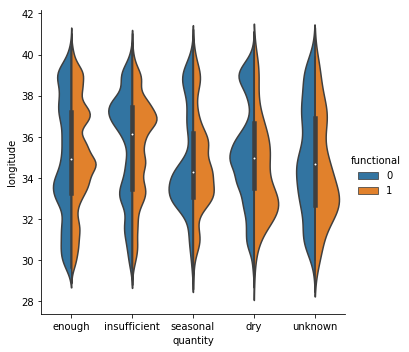

In [132]:
sns.catplot(x='quantity', y='longitude', hue='functional',
            kind='violin', split=True, data=train);

In [134]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='median'),
    DecisionTreeClassifier(min_samples_leaf=14, random_state=80)
)

pipeline.fit(X_train, y_train)
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

Train Accuracy 0.8221773288439955
Validation Accuracy 0.7734006734006734


In [135]:
y_pred = pipeline.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=['status_group'])

submission3 = pd.concat([submission_id, y_pred], axis=1)
submission3.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [0]:
submission3.to_csv('water-submission-05.csv', index = None, header=True)

In [158]:
best_10 = importances.sort_values(ascending=False)[:10].index.tolist()
best_10

['quantity_dry',
 'waterpoint_type_other',
 'longitude',
 'latitude',
 'time_to_inspection',
 'gps_height',
 'amount_tsh',
 'population',
 'waterpoint_type_communal standpipe multiple',
 'construction_year']

In [159]:
del best_10[0]
del best_10[0]
del best_10[6]
best_10.append('quantity')
best_10.append('waterpoint_type')
best_10

['longitude',
 'latitude',
 'time_to_inspection',
 'gps_height',
 'amount_tsh',
 'population',
 'construction_year',
 'quantity',
 'waterpoint_type']

In [161]:
X_train = train[best_10]
X_val = val[best_10]

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='median'),
    DecisionTreeClassifier(min_samples_leaf=14, random_state=80)
)

pipeline.fit(X_train, y_train)
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

Train Accuracy 0.8137598204264871
Validation Accuracy 0.7591919191919192


In [0]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

In [164]:
for i in range(1,20):
  print('Max depth:', i)
  pipeline = make_pipeline(
      ce.OneHotEncoder(use_cat_names=True),
      SimpleImputer(strategy='median'),
      DecisionTreeClassifier(min_samples_leaf=14, max_depth=i, random_state=80)
  )

  pipeline.fit(X_train, y_train)
  print('Train Accuracy', pipeline.score(X_train, y_train))
  print('Validation Accuracy', pipeline.score(X_val, y_val))

Max depth: 1
Train Accuracy 0.6413692480359147
Validation Accuracy 0.6451851851851852
Max depth: 2
Train Accuracy 0.6932435465768799
Validation Accuracy 0.6937373737373738
Max depth: 3
Train Accuracy 0.6932435465768799
Validation Accuracy 0.6937373737373738
Max depth: 4
Train Accuracy 0.7108866442199776
Validation Accuracy 0.7094949494949495
Max depth: 5
Train Accuracy 0.7171043771043771
Validation Accuracy 0.7150841750841751
Max depth: 6
Train Accuracy 0.7285521885521885
Validation Accuracy 0.7263973063973064
Max depth: 7
Train Accuracy 0.734006734006734
Validation Accuracy 0.7325252525252526
Max depth: 8
Train Accuracy 0.7399551066217733
Validation Accuracy 0.7322558922558923
Max depth: 9
Train Accuracy 0.7485297418630752
Validation Accuracy 0.74
Max depth: 10
Train Accuracy 0.7549943883277217
Validation Accuracy 0.7455892255892256
Max depth: 11
Train Accuracy 0.7614814814814815
Validation Accuracy 0.7485521885521885
Max depth: 12
Train Accuracy 0.7685521885521885
Validation Accuracy

In [165]:
for i in range(20,30):
  print('Max depth:', i)
  pipeline = make_pipeline(
      ce.OneHotEncoder(use_cat_names=True),
      SimpleImputer(strategy='median'),
      DecisionTreeClassifier(min_samples_leaf=14, max_depth=i, random_state=80)
  )

  pipeline.fit(X_train, y_train)
  print('Train Accuracy', pipeline.score(X_train, y_train))
  print('Validation Accuracy', pipeline.score(X_val, y_val))

Max depth: 20
Train Accuracy 0.8107519640852974
Validation Accuracy 0.7715151515151515
Max depth: 21
Train Accuracy 0.8134680134680135
Validation Accuracy 0.7734680134680134
Max depth: 22
Train Accuracy 0.8162289562289562
Validation Accuracy 0.7739393939393939
Max depth: 23
Train Accuracy 0.8178900112233446
Validation Accuracy 0.7741414141414141
Max depth: 24
Train Accuracy 0.819304152637486
Validation Accuracy 0.7731313131313131
Max depth: 25
Train Accuracy 0.8201122334455668
Validation Accuracy 0.774006734006734
Max depth: 26
Train Accuracy 0.8203591470258137
Validation Accuracy 0.7736026936026936
Max depth: 27
Train Accuracy 0.8210998877665544
Validation Accuracy 0.7734680134680134
Max depth: 28
Train Accuracy 0.8214365881032548
Validation Accuracy 0.7739393939393939
Max depth: 29
Train Accuracy 0.8216610549943884
Validation Accuracy 0.7743434343434343


In [166]:
for i in range(30,40):
  print('Max depth:', i)
  pipeline = make_pipeline(
      ce.OneHotEncoder(use_cat_names=True),
      SimpleImputer(strategy='median'),
      DecisionTreeClassifier(min_samples_leaf=14, max_depth=i, random_state=80)
  )

  pipeline.fit(X_train, y_train)
  print('Train Accuracy', pipeline.score(X_train, y_train))
  print('Validation Accuracy', pipeline.score(X_val, y_val))

Max depth: 30
Train Accuracy 0.8218181818181818
Validation Accuracy 0.7734006734006734
Max depth: 31
Train Accuracy 0.8221548821548822
Validation Accuracy 0.7736026936026936
Max depth: 32
Train Accuracy 0.8221773288439955
Validation Accuracy 0.7736026936026936
Max depth: 33
Train Accuracy 0.8221773288439955
Validation Accuracy 0.7734006734006734
Max depth: 34
Train Accuracy 0.8221773288439955
Validation Accuracy 0.7734006734006734
Max depth: 35
Train Accuracy 0.8221773288439955
Validation Accuracy 0.7734006734006734
Max depth: 36
Train Accuracy 0.8221773288439955
Validation Accuracy 0.7734006734006734
Max depth: 37
Train Accuracy 0.8221773288439955
Validation Accuracy 0.7734006734006734
Max depth: 38
Train Accuracy 0.8221773288439955
Validation Accuracy 0.7734006734006734
Max depth: 39
Train Accuracy 0.8221773288439955
Validation Accuracy 0.7734006734006734


In [168]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='median'),
    DecisionTreeClassifier(min_samples_leaf=14, max_depth=29, random_state=80)
)

pipeline.fit(X_train, y_train)
y_pred = pd.DataFrame(pipeline.predict(X_test), columns=['status_group'])
submission4 = pd.concat([submission_id, y_pred], axis=1)
submission4.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [0]:
submission4.to_csv('water-submission-06.csv', index=None, header=True)

In [171]:
train.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,population,construction_year,year_recorded,time_to_inspection,functional
count,44550.000000,44550.000000,29104.000000,43171.000000,43171.000000,44550.000000,28427.00000,44550.000000,44550.000000,44550.000000,44550.000000
mean,37143.024871,320.565308,1016.484779,35.153192,-5.895653,0.473692,282.31449,1996.885926,2011.920135,15.034209,0.543075
std,21404.799050,3150.477970,613.434859,2.604573,2.812980,11.594878,581.84945,10.058957,0.958777,10.095001,0.498147
min,0.000000,0.000000,-90.000000,29.607201,-11.649440,0.000000,1.00000,1960.000000,2002.000000,-7.000000,0.000000
25%,18674.250000,0.000000,391.000000,33.284972,-8.662794,0.000000,40.00000,1996.000000,2011.000000,8.000000,0.000000
50%,37112.500000,0.000000,1165.000000,35.001336,-5.177179,0.000000,150.00000,1997.000000,2012.000000,14.000000,1.000000
75%,55592.750000,25.000000,1498.000000,37.237524,-3.375576,0.000000,320.00000,2004.000000,2013.000000,16.000000,1.000000
max,74247.000000,350000.000000,2628.000000,40.344301,-0.998464,1776.000000,30500.00000,2013.000000,2013.000000,53.000000,1.000000
